# MLP-Mixer 图像分类

作者：[李启聪](https://gitee.com/ericleixd)。

本案例支持在GPU环境下运行。

## MLP-Mixer 简介

在计算机视觉(Computer Vision, CV)领域中，非常流行基于卷积的方法，最近，基于Transformer结构的方法也被证明有非常好的效果。但是MLP-Mixer模型的提出证明了在视觉领域卷积与Transformer不是必不可少的解决方案。MLP-Mixer通过两个MLP(Multi-Layer perceptrons)网络实现了一方面融合不同patch的信息(token-mixing)，一方面融合不同channel的信息(channel-mixing)，在ImageNet数据集上取得了不多的分类效果。

### 模型结构

MLP-Mixer 模型的主体结构是 Mixer 层，Mixer 层由 2 个 MLP 块组成。一个用于融合不同patch的信息，另一个用于融合不同channel的信息。每个MLP 块由两个全连接层的感知机和一个激活函数组成，其结构图[1]如下：

![show_images](image/mixer_architecture.jpeg)

### 模型特点

MLP-Mixer 模型主要应用于图像分类领域。因此，相较于传统的 CNN 和 ViT 有以下几个特点：

* 其架构依赖于在空间和特征通道上重复的各种矩阵乘法
* 验证了 MLP 的可能性

下面将通过代码实例来详细解释基于 MLP-Mixer 实现 Cifar10 分类任务。

## 环境准备与数据读取

开始实验之前，请确保本地已经安装了Python环境并安装了[MindSpore Vision套件](https://mindspore.cn/vision/docs/zh-CN/master/index.html)。

首先导入相关模块，配置相关超参数并读取数据集，该部分代码在MindSpore Vision套件中都有API可直接调用，详情可以参考以下链接：https://www.mindspore.cn/vision/docs/zh-CN/master/index.html 。

可通过<https://www.cs.toronto.edu/~kriz/cifar.html>下载完整的Cifar10数据集。

请确保你的数据集路径如以下结构。

```text
./data/
├── cifar-10-batches-py
│   ├── batches.meta
│   ├── data_batch_1
│   ├── data_batch_2
│   ├── data_batch_3
│   ├── data_batch_4
│   ├── data_batch_5
│   ├── readme.html
│   └── test_batch
└── cifar-10-python.tar.gz
```

In [1]:
import mindspore.dataset.vision.c_transforms as transforms
from mindvision.dataset import Cifar10

cifar10_dataset_dir = './data/'
resize = 224
batch_size = 64

normalize = transforms.Normalize(mean=(126.1, 123.7, 114.6),
                                 std=(62.9, 61.9, 66.7))

transform = [
    transforms.Resize(resize),
    normalize,
    transforms.HWC2CHW()
]

ds_train = Cifar10(path=cifar10_dataset_dir, shuffle=True, batch_size=batch_size, split='train', transform=transform)
ds_val = Cifar10(path=cifar10_dataset_dir, shuffle=True, batch_size=batch_size, split='test', transform=transform)

dataset_train = ds_train.run()
dataset_val = ds_val.run()

## 模型解析

下面将通过代码来细致剖析  MLP-Mixer 模型的内部结构。

### PatchEmbedding

Mixer 和 ViT 一样要先对图像进行patch化

假设输入的图片大小为：$ H \times W $

首先把图片分成很多个小正方形的patch，每个patch的大小定义为patch_size $ P $

patch / token 的数量：

$$
\begin{equation}
S = \frac{HW}{P^2}
\end{equation}
$$

隐藏维度 $C$ 也可以理解为 channel 的数量

In [2]:
from mindvision.classification.models.blocks import PatchEmbedding

patch_size = 16
image_channel = 3
C = 768

test_Patch = PatchEmbedding(image_size=resize,
                            patch_size=patch_size,
                            embed_dim=C,
                            input_channels=image_channel)

In [3]:
import numpy as np

from mindspore import Tensor
from mindspore import dtype as mstype

batch_size = 64

input_im = Tensor(np.ones([batch_size, image_channel, resize, resize]), mstype.float32)
print('[ 𝐵  3  𝐻  𝑊 ] : ', input_im.shape)
print('[ 𝐵  𝑆  𝐶 ] : ', test_Patch(input_im).shape)

[ 𝐵  3  𝐻  𝑊 ] :  (64, 3, 224, 224)
[ 𝐵  𝑆  𝐶 ] :  (64, 196, 768)


### Mixer 理解

现在很多视觉任务的网络架构，其实就是mix不同的特征，找出各个特征之间的关系来获取有用的信息。
从CNN的网络结构来理解就很简单了，如下图，拿一个4x4x3的kernel来举例，
4x4这两个维度其实就是来mix不同位置像素点的mixer，
而3这个维度则是来mix一个像素点不同通道特征的mixer。
MLP-Mixer将CNN这两个任务切割开来，用两个MLP网络来处理，
分别为 不同位置的mix叫做token-mixing 和 同一位置不同通道的mix叫做channel-mixing[2]。

![show_images](image/cnn-mixer.jpg)

### Mixer layer

每一个 mixer layer 由一个 token-mixer 以及 channel-mixer 组成，token-mixer作用于列(column)，混合提炼不同patch的特征；而channel-mixer作用于行(row)，混合提炼不同channel的特征。网络架构如下图所示，token-mixer以及channel-mixer中都包括一个 MLP 块，MLP 块的实现也很简单，两个全连接层中间以GELU（Gaussian Error Linear Units）作为激活函数。
mixer layer 可以用以下公式组成：

$$
\mathbf{U}  _{\ast} \text{ } , \text{ } _{i} = \mathbf{X} _{\ast} \text{ } , \text{ } _{i} + \mathbf{W} _2 \text{ } \sigma \left( \mathbf{W} _1 \text{ LayerNorm} \left( \mathbf{X} \right)  _{\ast} \text{ } , \text{ } _{i} \right) \text{ , for } i = 1 \ldots C \text{,}
$$

$$
\mathbf{Y}  _{j} \text{ } , \text{ } _{\ast} = \mathbf{U} _{j} \text{ } , \text{ } _{\ast} + \mathbf{W} _4 \text{ } \sigma \left( \mathbf{W} _3 \text{ LayerNorm} \left( \mathbf{U} \right)  _{j} \text{ } , \text{ } _{\ast} \right) \text{ , for } j = 1 \ldots S \text{,}
$$

当中，$ \textbf{W}_1 $ 和 $ \textbf{W}_2 $ 为 token-mixer 中两个全连接的权重，而$ \textbf{W}_3 $ 和 $ \textbf{W}_4 $ 为  channel-mixer 两个全连接的权重。$\sigma$ 表示GELU激活函数。
输入 $ \textbf{X} $ 经过Layer Normalize,再乘以$ \textbf{W}_1 $，再经过激活函数后乘以$ \textbf{W}_2 $，再加上 $ \textbf{X} $ (ResNet中的跨连结构) 。第二个公式也是相同的计算过程。Mixer Layer的输入维度和输出维度相同，并且通过MLP的方式来寻找图片像素与像素，通道与通道的关系[3]。

![show_images](image/mixer_layer.png)

In [4]:
from mindspore import nn
from mindspore.ops import operations as P

from mindvision.classification.models.blocks import FeedForward


class TokenMixer(nn.Cell):
    def __init__(self,
                 hidden_dim: int,
                 num_patches: int,
                 token_mlp_dim: int,
                 keep_prob: float = 1.0):
        super(TokenMixer, self).__init__()
        self.norm = nn.LayerNorm((hidden_dim,))
        self.transpose = P.Transpose()
        self.token_mixing_mlp = FeedForward(in_features=num_patches,
                                            hidden_features=token_mlp_dim,
                                            activation=nn.GELU,
                                            keep_prob=keep_prob)
    def construct(self, x):
        """Token Mixer construct."""
        x = self.norm(x)
        x = self.transpose(x, (0, 2, 1))
        x = self.token_mixing_mlp(x)
        x = self.transpose(x, (0, 2, 1))
        return x

class ChannelMixer(nn.Cell):
    def __init__(self,
                 hidden_dim: int,
                 channel_mlp_dim: int,
                 keep_prob: float = 1.0):
        super(ChannelMixer, self).__init__()
        self.norm = nn.LayerNorm((hidden_dim,))
        self.channel_mixing_mlp = FeedForward(in_features=hidden_dim,
                                              hidden_features=channel_mlp_dim,
                                              activation=nn.GELU,
                                              keep_prob=keep_prob)

    def construct(self, x):
        """Channel Mixer construct."""
        x = self.norm(x)
        x = self.channel_mixing_mlp(x)
        return x

class MixerBlock(nn.Cell):
    def __init__(self,
                 hidden_dim: int,
                 num_patches: int,
                 token_mlp_dim: int,
                 channel_mlp_dim: int,
                 keep_prob: float = 1.0):
        super(MixerBlock, self).__init__()
        self.token_mixer = TokenMixer(hidden_dim=hidden_dim,
                                      num_patches=num_patches,
                                      token_mlp_dim=token_mlp_dim,
                                      keep_prob=keep_prob)
        self.channel_mixer = ChannelMixer(hidden_dim=hidden_dim,
                                          channel_mlp_dim=channel_mlp_dim,
                                          keep_prob=keep_prob)

    def construct(self, x):
        """Mixer Block construct."""
        x += self.token_mixer(x)
        x += self.channel_mixer(x)
        return x

class DeepMixerBlock(nn.Cell):
    def __init__(self,
                 num_blocks: int = 12,
                 hidden_dim: int = 768,
                 num_patches: int = 196,
                 token_mlp_dim: int = 384,
                 channel_mlp_dim: int = 3072,
                 keep_prob: float = 1.0):
        super(DeepMixerBlock, self).__init__()
        layers = []
        for _ in range(num_blocks):
            layers.append(
                MixerBlock(hidden_dim=hidden_dim,
                           num_patches=num_patches,
                           token_mlp_dim=token_mlp_dim,
                           channel_mlp_dim=channel_mlp_dim,
                           keep_prob=keep_prob)
            )
        self.layers = nn.SequentialCell(layers)

    def construct(self, x):
        """Deep Mixer Block construct."""
        return self.layers(x)

### 整体构建 MLP-Mixer

以下代码构建了一个完整的MLP-Mixer模型。

In [5]:
from mindvision.classification.models.blocks import PatchEmbedding

class Mixer(nn.Cell):
    def __init__(self,
                 image_size: int = 224,
                 input_channels: int = 3,
                 patch_size: int = 16,
                 num_blocks: int = 12,
                 hidden_dim: int = 768,
                 token_mlp_dim: int = 384,
                 channel_mlp_dim: int = 3072,
                 keep_prob: float = 1.0):
        super(Mixer, self).__init__()
        self.patch_embedding = PatchEmbedding(image_size=image_size,
                                              patch_size=patch_size,
                                              embed_dim=hidden_dim,
                                              input_channels=input_channels)
        self.num_patches = self.patch_embedding.num_patches
        self.mixer_blocks = DeepMixerBlock(num_blocks=num_blocks,
                                           hidden_dim=hidden_dim,
                                           num_patches=self.num_patches,
                                           token_mlp_dim=token_mlp_dim,
                                           channel_mlp_dim=channel_mlp_dim)
        self.norm = nn.LayerNorm((hidden_dim,))
        self.avg_global_pool = P.ReduceMean(keep_dims=False)

    def construct(self, x):
        """MLP-Mixer construct."""
        x = self.patch_embedding(x)
        x = self.mixer_blocks(x)
        x = self.norm(x)
        x = self.avg_global_pool(x, 1)
        return x

In [6]:
import ml_collections as collections
from typing import Optional

from mindspore import nn

from mindvision.classification.models.classifiers import BaseClassifier
from mindvision.classification.models.head import DenseHead, MultilayerDenseHead

def mixer(image_size: int,
          input_channels: int,
          patch_size: int,
          embed_dim: int,
          num_layers: int,
          token_mlp_dim: int,
          channel_mlp_dim: int,
          num_classes: int,
          dropout: float = 0.,
          arch: str = None,
          pretrained: bool = False,
          representation_size: Optional[int] = None) -> Mixer:
    """MLP-Mixer architecture."""
    backbone = Mixer(image_size=image_size,
                     input_channels=input_channels,
                     patch_size=patch_size,
                     num_blocks=num_layers,
                     hidden_dim=embed_dim,
                     token_mlp_dim=token_mlp_dim,
                     channel_mlp_dim=channel_mlp_dim,
                     keep_prob=1.0 - dropout)
    if representation_size:
        head = MultilayerDenseHead(input_channel=embed_dim,
                                   num_classes=num_classes,
                                   mid_channel=[representation_size],
                                   activation=['tanh', None],
                                   keep_prob=[1.0, 1.0])
    else:
        head = DenseHead(input_channel=embed_dim,
                         num_classes=num_classes)
    model = BaseClassifier(backbone=backbone, head=head)
    return model

def Mixer_b_16(num_classes: int = 10,
               image_size: int = 224,
               has_logits: bool = False,
               pretrained: bool = False,
               drop_out: float = 0.0
              ) -> Mixer:

    config = collections.ConfigDict()
    config.arch = 'Mixer_b_16_' + str(image_size)
    config.image_size = image_size
    config.num_classes = num_classes
    config.patch_size = 16
    config.embed_dim = 768
    config.token_mlp_dim = 384
    config.channel_mlp_dim = 3072
    config.num_layers = 12
    config.dropout = drop_out
    config.input_channels = 3
    config.representation_size = 1024 if has_logits else None

    return mixer(**config)

## 模型训练与推理

### 加载预训练模型

我们针对使用 GSAM 方法 ImageNet 预训练的 五个 MLP-Mixer 模型对 Cifar10 进行微调(fine-tune), 本案例使用

可以通过下面的链接下载 MindSpore 模型：

https://download.mindspore.cn/vision/mlpmixer/gsam_Mixer-B_16.ckpt

把下载好的模型文件路径如以下结构。

```text
./ms_ckpt/
├── gsam_Mixer-B_16.ckpt
```

In [7]:
from mindspore import load_checkpoint, load_param_into_net

num_classes = 10
model_name = 'gsam_Mixer-B_16'
net_dir = './ms_ckpt/'
ckpt_file_name = net_dir + model_name + '.ckpt'

param_dict = load_checkpoint(ckpt_file_name)
net = Mixer_b_16(num_classes=num_classes)
param_not_load = load_param_into_net(net, param_dict)

### 模型训练

模型开始训练前，需要设定损失函数，优化器，回调函数等，调用MindSpore GPU 接口可以加速训练。

完整训练MLP-Mixer模型需要很长的时间，实际应用时建议根据项目需要调整epoch_size，当正常输出每个Epoch的step信息时，意味着训练正在进行，通过模型输出可以查看当前训练的loss值和时间等指标。

In [8]:
import mindspore.nn as nn
from mindspore import Model
from mindspore import set_context, GRAPH_MODE
from mindspore.train.callback import CheckpointConfig, ModelCheckpoint

from mindvision.engine.callback import LossMonitor
from mindvision.engine.loss import CrossEntropySmooth

# 设定 GPU
set_context(mode=GRAPH_MODE, device_target='GPU')

# 定义超参数
epoch_size = 3
momentum = 0.9
step_size = dataset_train.get_dataset_size()

# 构建模型
network = net

# 定义递减的学习率
lr = nn.cosine_decay_lr(min_lr=0.0000005,
                        max_lr=0.0006,
                        total_step=epoch_size * step_size,
                        step_per_epoch=step_size,
                        decay_epoch=epoch_size)

# 定义优化器
network_opt = nn.SGD(network.trainable_params(), lr, momentum)

# 定义损失函数
network_loss = CrossEntropySmooth(sparse=True,
                                  reduction="mean",
                                  smooth_factor=0.1,
                                  classes_num=num_classes)

# 设定checkpoint
ckpt_config = CheckpointConfig(save_checkpoint_steps=step_size, keep_checkpoint_max=100)
ckpt_callback = ModelCheckpoint(prefix='Mixer_b_16', directory='./Mixer', config=ckpt_config)

# 初始化模型
eval_metrics = {'Top_1_Accuracy': nn.Top1CategoricalAccuracy(),
                'Top_5_Accuracy': nn.Top5CategoricalAccuracy()}

model = Model(network, loss_fn=network_loss, optimizer=network_opt, metrics=eval_metrics)

# 训练
model.train(epoch_size,
            dataset_train,
            callbacks=[ckpt_callback, LossMonitor(lr)],
            dataset_sink_mode=False)

Epoch:[  0/  3], step:[    1/  781], loss:[0.593/0.593], time:3726.624 ms, lr:0.00060
Epoch:[  0/  3], step:[    2/  781], loss:[0.609/0.601], time:782.007 ms, lr:0.00060
Epoch:[  0/  3], step:[    3/  781], loss:[0.656/0.619], time:782.141 ms, lr:0.00060
Epoch:[  0/  3], step:[    4/  781], loss:[0.555/0.603], time:784.899 ms, lr:0.00060
Epoch:[  0/  3], step:[    5/  781], loss:[0.601/0.603], time:783.482 ms, lr:0.00060
...
Epoch:[  2/  3], step:[  777/  781], loss:[0.556/0.562], time:798.492 ms, lr:0.00015
Epoch:[  2/  3], step:[  778/  781], loss:[0.557/0.562], time:799.714 ms, lr:0.00015
Epoch:[  2/  3], step:[  779/  781], loss:[0.559/0.562], time:798.585 ms, lr:0.00015
Epoch:[  2/  3], step:[  780/  781], loss:[0.554/0.562], time:796.188 ms, lr:0.00015
Epoch:[  2/  3], step:[  781/  781], loss:[0.580/0.562], time:2247.070 ms, lr:0.00015
Epoch time: 658629.371 ms, per step time: 843.315 ms, avg loss: 0.562


### 模型验证

In [9]:
result = model.eval(dataset_val)
print(result)

{'Top_1_Accuracy': 0.9686498397435898, 'Top_5_Accuracy': 0.9983974358974359}


### 模型推理

在进行模型推理之前，首先要定义一个对推理图片进行数据预处理的方法。该方法可以对我们的推理图片进行resize和normalize处理，这样才能与我们训练时的输入数据匹配。

本案例十张图片，分别对应 Cifar10 的十个标签。

In [10]:
import mindspore.dataset.vision.c_transforms as transforms
from mindspore.dataset.transforms.c_transforms import Compose

resize = 224

normalize = transforms.Normalize(mean=(126.1, 123.7, 114.6),
                                 std=(62.9, 61.9, 66.7))

transform = [
    transforms.Resize((resize, resize)),
    normalize,
    transforms.HWC2CHW()
]

transform_func = Compose(transform)

label_list = ['airplane',
              'automobile',
              'bird',
              'cat',
              'deer',
              'dog',
              'frog',
              'horse',
              'ship',
              'truck']

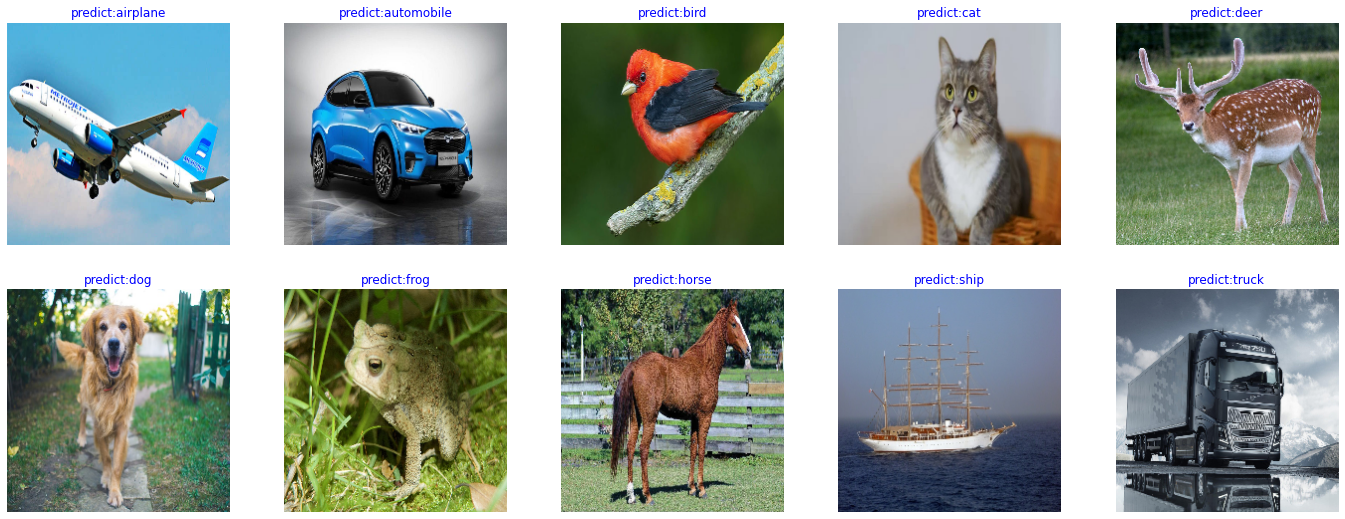

In [12]:
import matplotlib.pyplot as plt

import cv2

from mindspore import Tensor

infer_fig_dir = './infer/'

plt.figure(figsize=(24, 9))
for i in range(len(label_list)):
    plt.subplot(2, 5, i + 1)
    origin_img = cv2.imread(infer_fig_dir + label_list[i] + '.jpeg')
    prob = model.predict(Tensor(np.expand_dims(transform_func(origin_img), axis=0)))
    label = np.argmax(prob.asnumpy(), axis=1)
    predict = ds_val.index2label[int(label)]
    color = 'blue' if label_list[i] == predict else 'red'
    plt.title('predict:{}'.format(predict), color=color)
    img_show = cv2.resize(origin_img, (224, 224))
    plt.imshow(img_show[..., ::-1])
    plt.axis('off')

plt.show()

## 总结

本案例完成了一个 MLP-Mixer 模型在 cifar10 数据上进行训练，验证和推理的过程，其中，对关键的 MLP-Mixer 模型结构和原理作了讲解。通过学习本案例，理解源码可以帮助用户掌握Mixer关键概念。

## 引用

[1]. Tolstikhin I O, Houlsby N, Kolesnikov A, et al. Mlp-mixer: An all-mlp architecture for vision[J]. Advances in Neural Information Processing Systems, 2021, 34: 24261-24272.

[2]. https://zhuanlan.zhihu.com/p/372692759

[3]. https://blog.csdn.net/qq_38676487/article/details/118640096